In [295]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crowdflower-search-relevance/train.csv.zip
/kaggle/input/crowdflower-search-relevance/sampleSubmission.csv.zip
/kaggle/input/crowdflower-search-relevance/test.csv.zip


In [296]:
import os
import wandb
from wandb.keras import WandbCallback
os.system('! wandb login be213aaff4ff14945d480abc18697d8664bba8c8')
training = pd.read_csv('/kaggle/input/crowdflower-search-relevance/train.csv.zip')
test = pd.read_csv('/kaggle/input/crowdflower-search-relevance/test.csv.zip')
test['relevance_variance'] = np.NaN
training['train_test'] = 1
training = training.drop(['product_description'], axis=1)
test['train_test'] = 0
all_data = pd.concat([training,test]) 
print(training.head())
print(test.head())
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
attribute_names = all_data.columns.tolist()
test_atts = test.columns.tolist()
all_dummies = pd.get_dummies(all_data[attribute_names])
test_dummies = pd.get_dummies(test[test_atts])  
X_train = all_dummies[all_data.train_test == 1].drop(['train_test'], axis=1)
for column in X_train.columns:
    mean_value = X_train[column].mean()
    X_train[column].fillna(mean_value, inplace=True)
X_check = X_train #for heatmap
X_train = X_train.drop(['relevance_variance'], axis=1)
X_backup = X_train
X_test = all_dummies[all_data.train_test == 0].drop(['train_test'], axis=1)
y_train = all_data[all_data.train_test==1].relevance_variance
y_backup = y_train
X_test = X_test.drop(['relevance_variance'], axis=1)
for column in X_test.columns:
    mean_value = X_test[column].mean()
    X_test[column].fillna(mean_value, inplace=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


   id                      query  \
0   1  bridal shower decorations   
1   2       led christmas lights   
2   4                  projector   
3   5                  wine rack   
4   7                 light bulb   

                                       product_title  median_relevance  \
0        Accent Pillow with Heart Design - Red/Black                 1   
1  Set of 10 Battery Operated Multi LED Train Chr...                 4   
2         ViewSonic Pro8200 DLP Multimedia Projector                 4   
3  Concept Housewares WR-44526 Solid-Wood Ceiling...                 4   
4  Wintergreen Lighting Christmas LED Light Bulb ...                 2   

   relevance_variance  train_test  
0               0.000           1  
1               0.000           1  
2               0.471           1  
3               0.000           1  
4               0.471           1  
   id                           query  \
0   3                electric griddle   
1   6           phillips coffee maker   

In [297]:
print(training)

          id                       query  \
0          1   bridal shower decorations   
1          2        led christmas lights   
2          4                   projector   
3          5                   wine rack   
4          7                  light bulb   
...      ...                         ...   
10153  32655  plantronics corded headset   
10154  32659                   spiderman   
10155  32663     playstation vita system   
10156  32666                flower bulbs   
10157  32668    polar heart rate monitor   

                                           product_title  median_relevance  \
0            Accent Pillow with Heart Design - Red/Black                 1   
1      Set of 10 Battery Operated Multi LED Train Chr...                 4   
2             ViewSonic Pro8200 DLP Multimedia Projector                 4   
3      Concept Housewares WR-44526 Solid-Wood Ceiling...                 4   
4      Wintergreen Lighting Christmas LED Light Bulb ...                 2   
...

In [298]:
print(test)

          id                           query  \
0          3                electric griddle   
1          6           phillips coffee maker   
2          9             san francisco 49ers   
3         11                  aveeno shampoo   
4         12  flea and tick control for dogs   
...      ...                             ...   
22508  32665           seagate 2tb hard disk   
22509  32667                 storage ottoman   
22510  32669                      gym gloves   
22511  32670                  wreck it ralph   
22512  32671                hair accessories   

                                           product_title  \
0                        Star-Max 48 in Electric Griddle   
1      Philips SENSEO HD7810 WHITE Single Serve Pod C...   
2                         2013 San Francisco 49ers Clock   
3                    AVEENO       10.5FLOZ NRSH SHINE SH   
4      Merial Frontline Plus Flea and Tick Control fo...   
...                                                  ...   
225

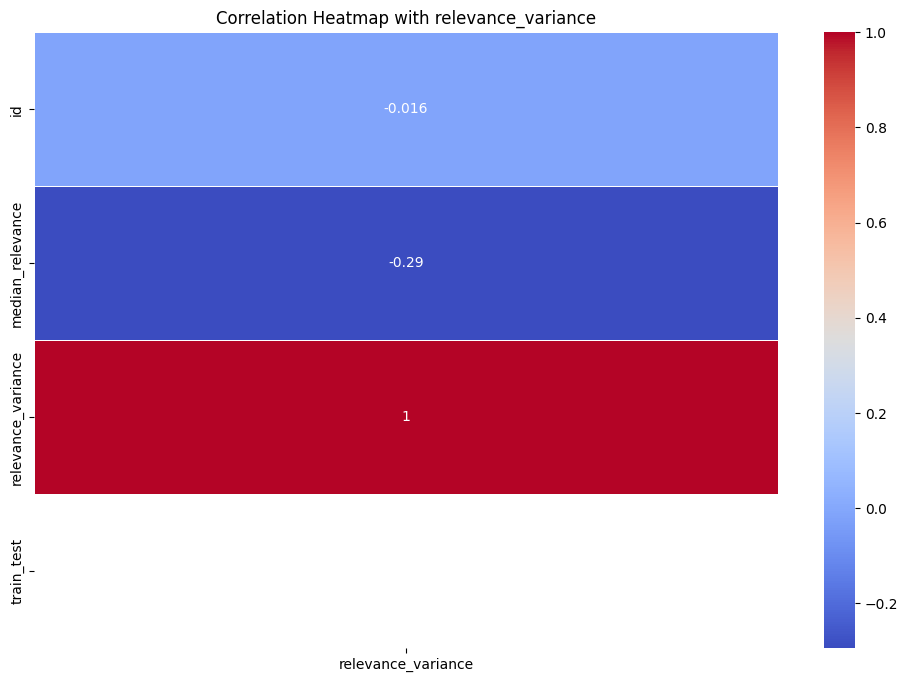

In [299]:
import matplotlib.pyplot as plt

target_variable = 'relevance_variance'
numeric_data = training.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[[target_variable]], annot=True, cmap='coolwarm', linewidths=.5)

plt.title(f'Correlation Heatmap with {target_variable}')
plt.show()

#due to the lack of numerical values, these types of visualization provide little information

In [300]:
'''target_variable = 'relevance_variance'
correlations = X_train.corr()[target_column]
correlations = correlations.drop(target_variable)
# Filter features with a correlation of at least 0.4 or -0.4
significant_features = correlations[(correlations >= 0.1) | (correlations <= -0.1)]
significant_features_index = correlations[(correlations >= 0.1) | (correlations <= -0.1)].index
print(significant_features)
print(significant_features_index)

plt.figure(figsize=(10, 6))
sns.barplot(x=significant_features.values, y=significant_features.index)
plt.title(f'Features Correlating at least 0.1 or -0.1 with {target_column}')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()'''

"target_variable = 'relevance_variance'\ncorrelations = X_train.corr()[target_column]\ncorrelations = correlations.drop(target_variable)\n# Filter features with a correlation of at least 0.4 or -0.4\nsignificant_features = correlations[(correlations >= 0.1) | (correlations <= -0.1)]\nsignificant_features_index = correlations[(correlations >= 0.1) | (correlations <= -0.1)].index\nprint(significant_features)\nprint(significant_features_index)\n\nplt.figure(figsize=(10, 6))\nsns.barplot(x=significant_features.values, y=significant_features.index)\nplt.title(f'Features Correlating at least 0.1 or -0.1 with {target_column}')\nplt.xlabel('Correlation')\nplt.ylabel('Features')\nplt.show()"

/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


###############
            Feature  Correlation        P-Value
0  median_relevance    -0.293887  1.670692e-201
###############
median_relevance: -0.29388694843706425
query_coffee for nespresso: 0.05340298398652817
query_san francisco 49ers: 0.0676767698009354


<Figure size 1600x800 with 0 Axes>

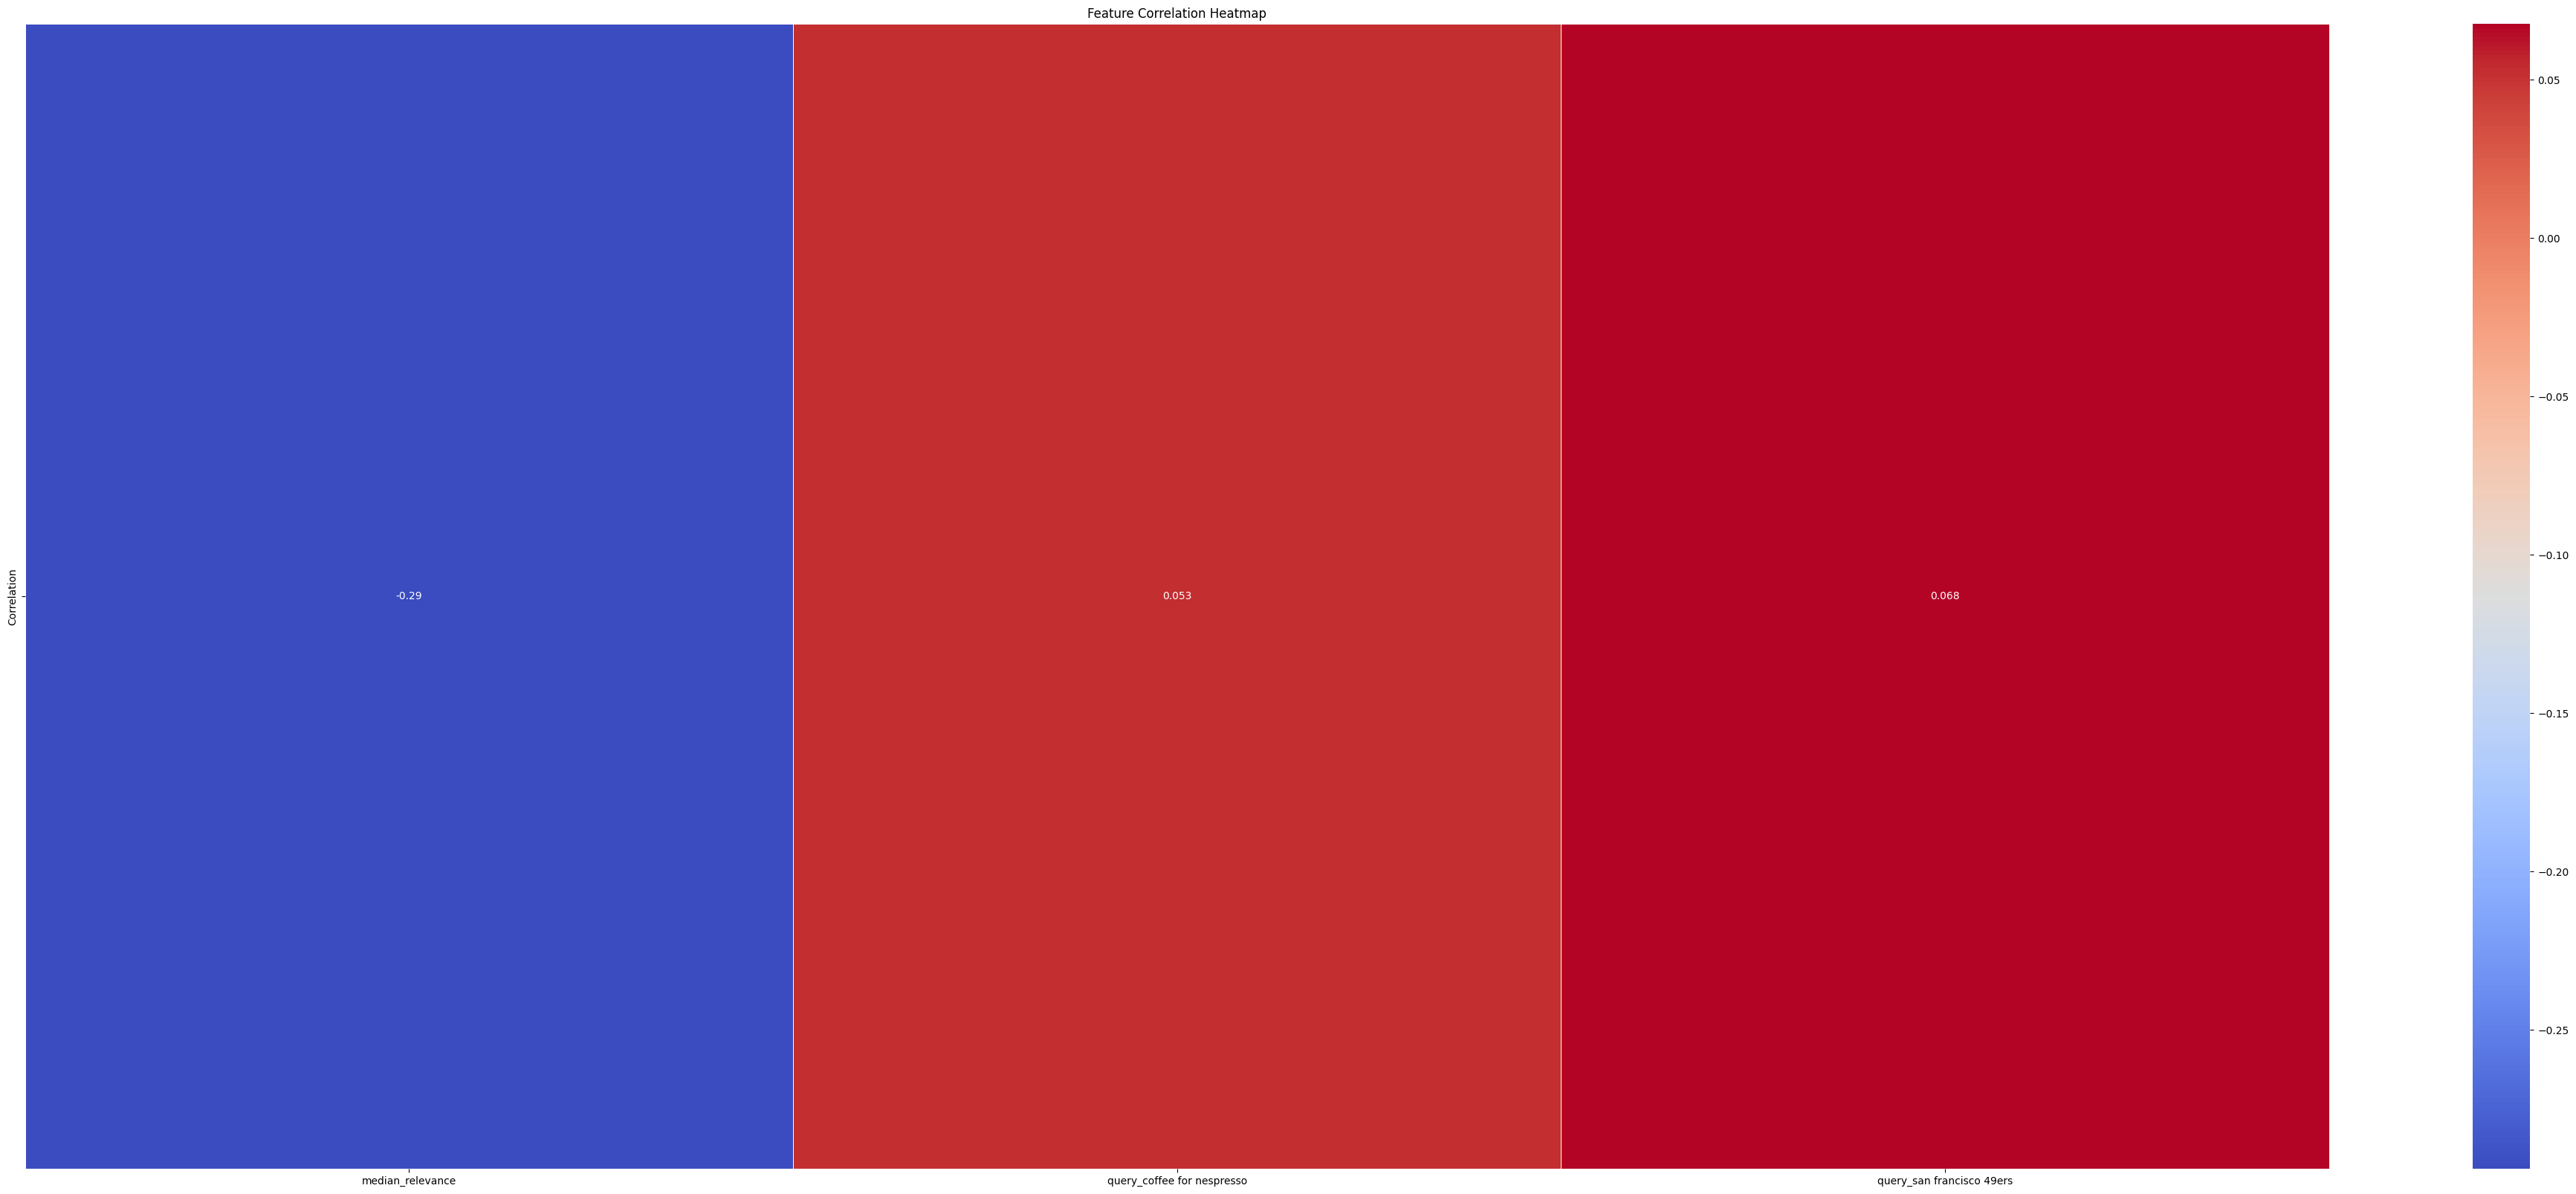

'for column in X_train.columns:\n    if X_train[column].nunique() == 2:  \n        plt.subplot(1, 2, 1)\n        sns.countplot(x=column, data=all_train)\n        plt.title(f\'Prevalence of {column} being 1\')\n\n        plt.subplot(1, 2, 2)\n        correlation = full_dataset[column].corr(y_train)\n        sns.barplot(x=[column], y=[correlation])\n        correlations[column] = correlation\n\nplt.show()\n\n# Display correlation values\nprint("Correlation with the target variable:")\nfor feature, correlation in correlations.items():\n    print(f"{feature}: {correlation:.2f}")'

In [301]:
all_train = pd.concat([X_train, y_train], axis=1)

def create_splits(X_train, y_train, num_splits):
    total_features = X_train.shape[1]
    features_per_subset = total_features // num_splits
    all_train_splits = []
    for i in range(num_splits):
        start_idx = i * features_per_subset
        end_idx = (i + 1) * features_per_subset if i < num_splits - 1 else total_features
        subset_features = X_train.iloc[:, start_idx:end_idx]
        all_train_subset = pd.concat([subset_features, y_train], axis=1)
        all_train_splits.append(all_train_subset)

    return all_train_splits

num_splits = 100
all_train_splits = create_splits(X_train, y_train, num_splits)


#print(all_train_splits[0].head())
plt.figure(figsize=(16, 8))
correlations = {}

from scipy.stats import pearsonr

def feature_stats(dataset, targ, correlation_threshold=0.1):
    features = dataset.drop(columns=[targ])
    target = dataset[targ]
    correlation_results = [pearsonr(features[feature], target) for feature in features.columns]
    selected_positive = [(feature, corr, p) for (feature, (corr, p)) in zip(features.columns, correlation_results) if corr >= correlation_threshold]
    selected_negative = [(feature, corr, p) for (feature, (corr, p)) in zip(features.columns, correlation_results) if corr <= -correlation_threshold]

    # Create a DataFrame to store the results
    stats_df = pd.DataFrame({
        'Feature': [item[0] for item in selected_positive + selected_negative],
        'Correlation': [item[1] for item in selected_positive + selected_negative],
        'P-Value': [item[2] for item in selected_positive + selected_negative],
    })

    return stats_df

stats_all_train_splits_0 = feature_stats(all_train_splits[0], 'relevance_variance')
print('###############')
print(stats_all_train_splits_0)
print('###############')


def plot_feature_heatmap(dataset, targ, correlation_threshold=0.05):
    # Extract features and target
    features = dataset.drop(columns=[targ])  
    target = dataset[targ]
    feature_correlation = features.corrwith(target)
    selected_features = feature_correlation[(feature_correlation >= correlation_threshold) | (feature_correlation <= -correlation_threshold)]

    # Create a DataFrame to store the results
    corr_df = pd.DataFrame({'Correlation': selected_features})
    feature_correlation_list = list(zip(selected_features.index, selected_features.values))
    for feature, correlation in feature_correlation_list:
        print(f"{feature}: {correlation}")
    if not corr_df.empty:
        plt.figure(figsize=(50, 20))
        sns.heatmap(corr_df.transpose(), annot=True, cmap='coolwarm', linewidths=.5)
        plt.title('Feature Correlation Heatmap')
        plt.show()
    #else:
        #print("No features meet the correlation threshold criteria.")

    return feature_correlation_list

#plot_feature_heatmap(all_train_splits[0], 'relevance_variance')


median_relevance: -0.29388694843706425
query_coffee for nespresso: 0.05340298398652817
query_san francisco 49ers: 0.0676767698009354


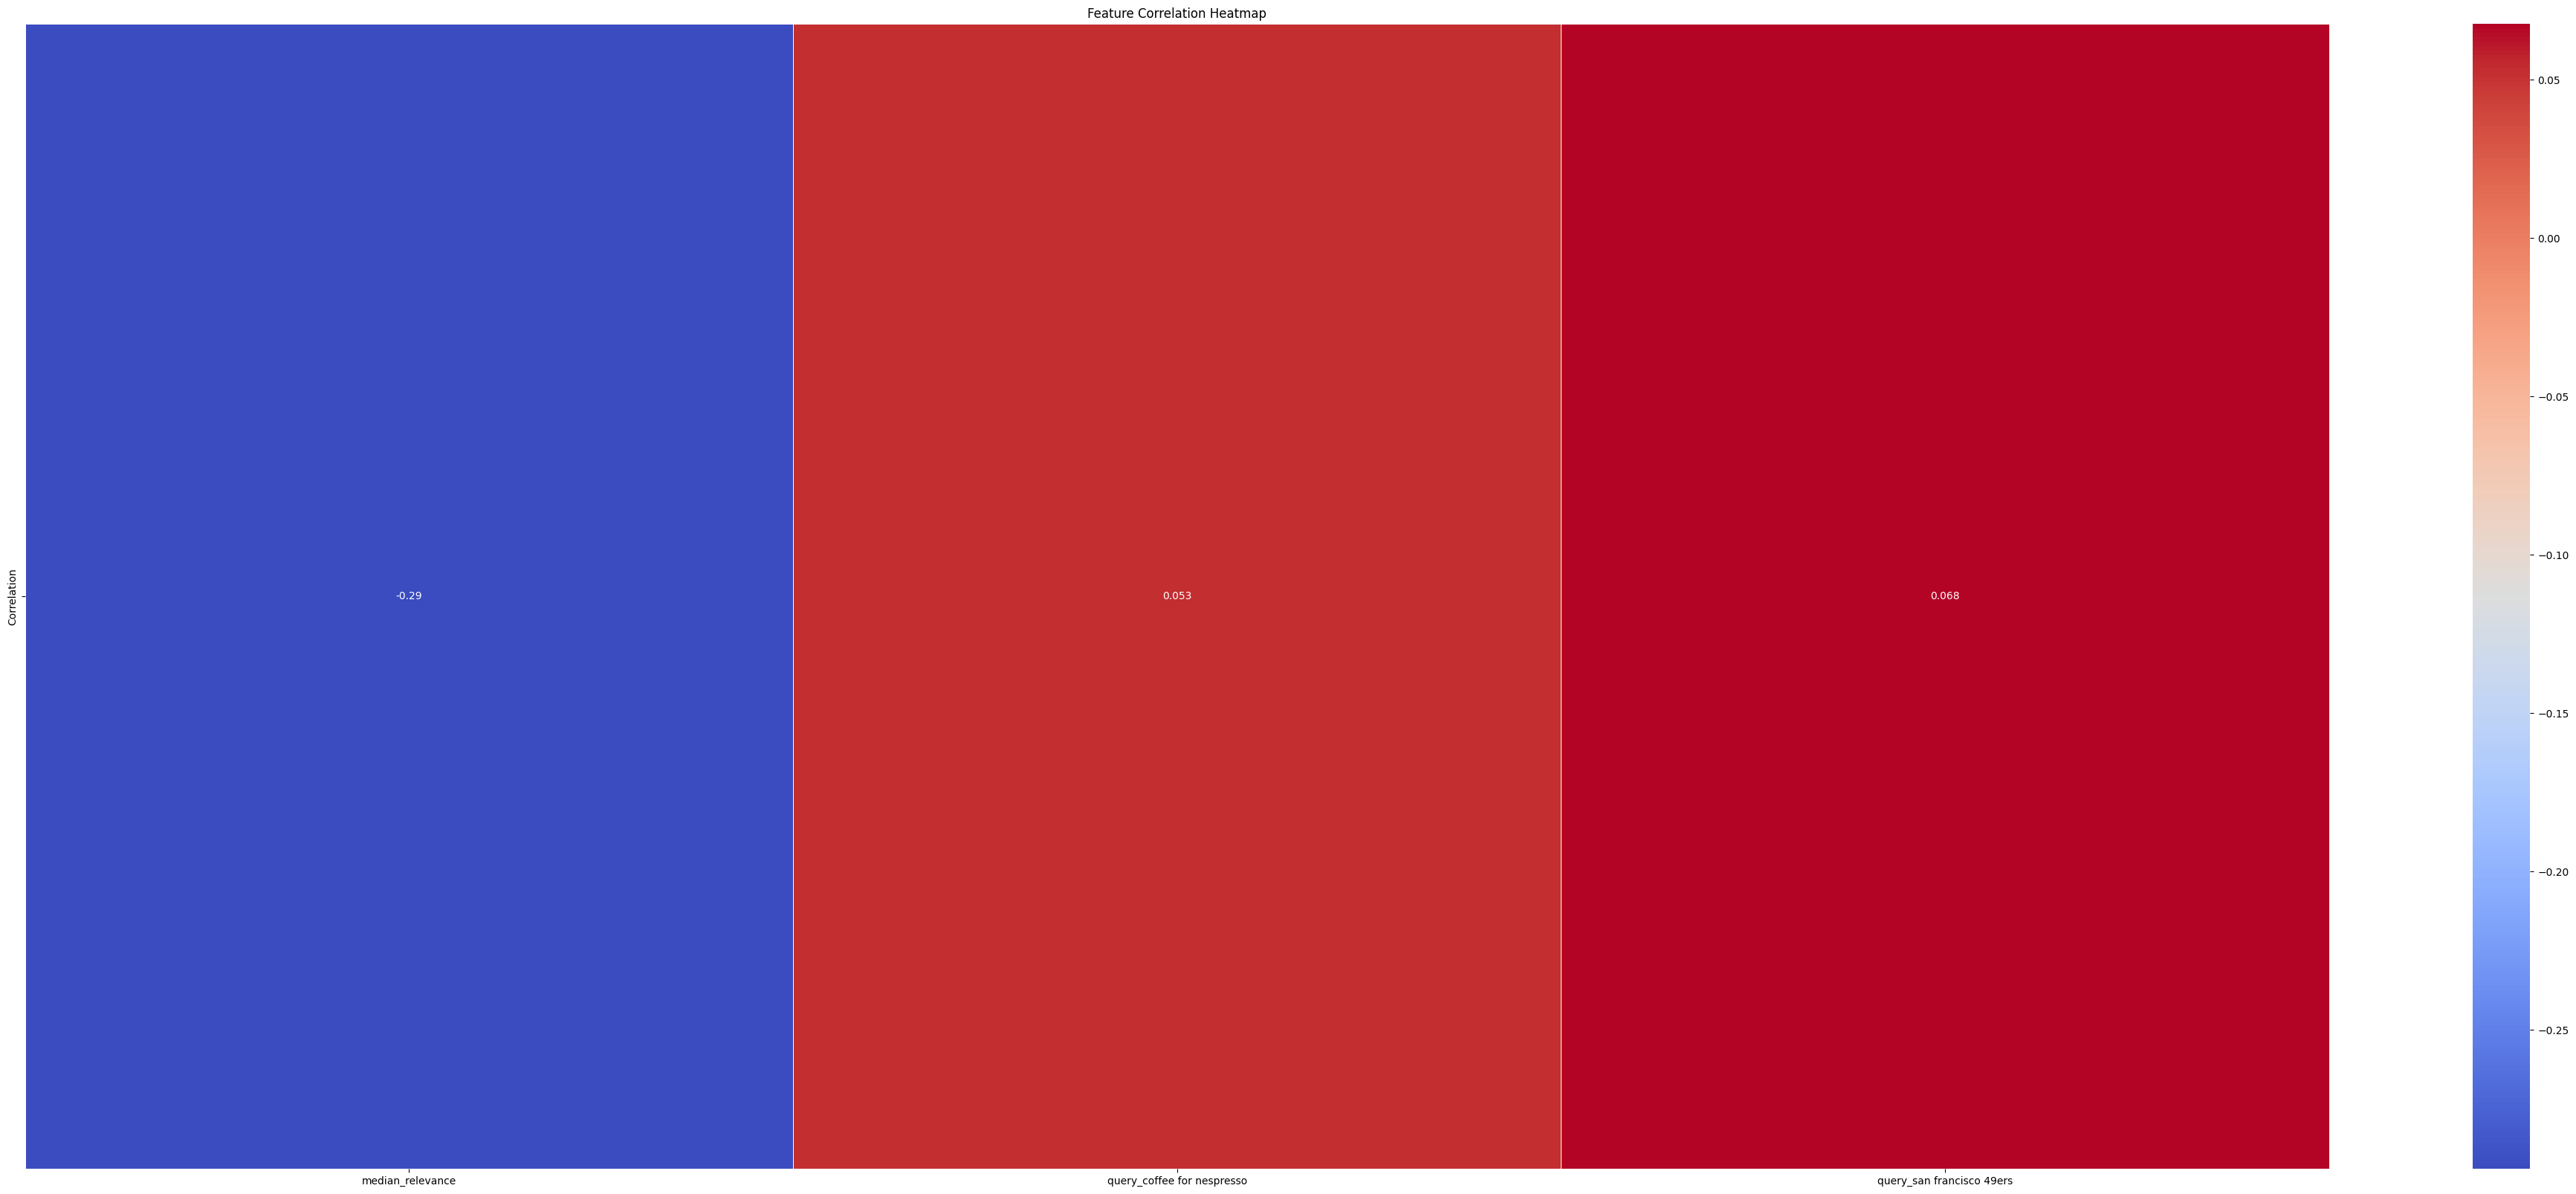

In [302]:
for i in range(100):
    print('###############')
    plot_feature_heatmap(all_train_splits[i], 'relevance_variance')
    stats_all_train_splits_0 = feature_stats(all_train_splits[i], 'relevance_variance')
    print(stats_all_train_splits_0)
    print('###############')

In [305]:
#plot_significance(all_train_1, all_train_1['relevance_variance'], 'Split 1')

In [306]:
#attribute_names = X_train.columns.tolist()
#print(attribute_names)